In [120]:
import numpy as np
import torch
import platform

print(f'Pytorch version: {torch.__version__}')
print(f'cuda version: {torch.version.cuda}')
print(f'Python version: {platform.python_version()}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using:',device)

Pytorch version: 1.11.0
cuda version: 11.3
Python version: 3.8.13
using: cuda


![The LeNet-5](LeNet-5.jpg)
The LeNet-5 network

In [121]:
from torch import nn
LeNet_5 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [122]:
#shape test
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in LeNet_5:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [123]:
import torchvision
from torchvision.transforms import ToTensor
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

batch_size = 256
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

In [124]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def eval(model, test_loader, device):
    model.eval()
    correct_num = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            y_predicted = y_hat.argmax(axis=1)
            cmp = y_predicted == y
            correct_num += float(cmp.sum())
    epoch_acc = correct_num / len(test_loader.dataset)
    return epoch_acc

In [125]:
import matplotlib.pyplot as plt
'''
kernel died reason: expect parameters to be list not tensor!!!
'''
def visualize_training(num_epochs, train_losses, train_accs, test_accs):
    epochs = range(num_epochs)
    plt.plot(epochs, train_losses, 'b-', label='train loss')
    plt.plot(epochs, train_accs, 'r--', label='train acc')
    plt.plot(epochs, test_accs, 'g-.', label='test acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [126]:
def training_loop(model, train_loader, test_loader, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        # train
        model, optimizer, train_loss = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        # eval
        train_acc = eval(model, train_loader, device)
        train_accs.append(train_acc)
        test_acc = eval(model, test_loader, device)
        test_accs.append(test_acc)
        print("Epoch [{}/{}] Train Loss:{} Train Accuracy:{} Test Accuracy:{}".format(epoch+1, num_epochs, train_loss, train_acc, test_acc))
        # print(num_epochs, train_losses, train_accs, test_accs)
    visualize_training(num_epochs, train_losses, train_accs, test_accs)

Epoch [1/20] Train Loss:2.309666748682658 Train Accuracy:0.09751666666666667 Test Accuracy:0.0974
Epoch [2/20] Train Loss:2.3073364676157633 Train Accuracy:0.09751666666666667 Test Accuracy:0.0974
Epoch [3/20] Train Loss:2.305519260152181 Train Accuracy:0.09751666666666667 Test Accuracy:0.0974
Epoch [4/20] Train Loss:2.302498369471232 Train Accuracy:0.09903333333333333 Test Accuracy:0.0979
Epoch [5/20] Train Loss:2.283988603591919 Train Accuracy:0.4664 Test Accuracy:0.4643
Epoch [6/20] Train Loss:1.657689245033264 Train Accuracy:0.7108333333333333 Test Accuracy:0.7178
Epoch [7/20] Train Loss:0.7384447990735372 Train Accuracy:0.7646666666666667 Test Accuracy:0.7717
Epoch [8/20] Train Loss:0.5132547600746155 Train Accuracy:0.8146333333333333 Test Accuracy:0.8217
Epoch [9/20] Train Loss:0.40571594130198163 Train Accuracy:0.8507666666666667 Test Accuracy:0.8573
Epoch [10/20] Train Loss:0.3441659370581309 Train Accuracy:0.8744833333333333 Test Accuracy:0.8805
Epoch [11/20] Train Loss:0.3015

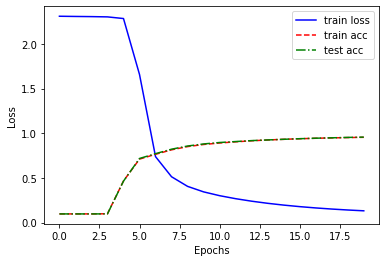

In [127]:
lr = 0.9
num_epochs = 20
training_loop(LeNet_5, train_loader, test_loader, num_epochs, lr, device)

Epoch [1/20] Train Loss:2.3091514428456623 Train Accuracy:0.09751666666666667 Test Accuracy:0.0974
Epoch [2/20] Train Loss:2.304913013839722 Train Accuracy:0.09751666666666667 Test Accuracy:0.0974
Epoch [3/20] Train Loss:2.2943076602935792 Train Accuracy:0.22743333333333332 Test Accuracy:0.2305
Epoch [4/20] Train Loss:1.9952257873535155 Train Accuracy:0.52895 Test Accuracy:0.5311
Epoch [5/20] Train Loss:1.0810896277427673 Train Accuracy:0.7288333333333333 Test Accuracy:0.7308
Epoch [6/20] Train Loss:0.6644079535484314 Train Accuracy:0.7881833333333333 Test Accuracy:0.7943
Epoch [7/20] Train Loss:0.48609284699757893 Train Accuracy:0.8256833333333333 Test Accuracy:0.8353
Epoch [8/20] Train Loss:0.39768664797147113 Train Accuracy:0.8454833333333334 Test Accuracy:0.8556
Epoch [9/20] Train Loss:0.35023857836723327 Train Accuracy:0.8583166666666666 Test Accuracy:0.8687
Epoch [10/20] Train Loss:0.31805093156496683 Train Accuracy:0.86825 Test Accuracy:0.8769
Epoch [11/20] Train Loss:0.29229731

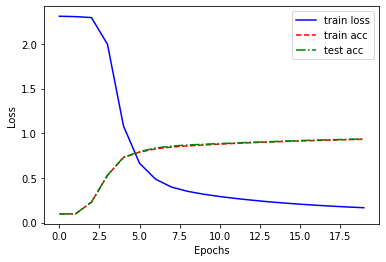

In [128]:
LeNet_5_half_conv_core = nn.Sequential(
    nn.Conv2d(1, 3, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(3, 8, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(8 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
    
training_loop(LeNet_5_half_conv_core, train_loader, test_loader, num_epochs, lr, device)

Epoch [1/20] Train Loss:2.3223594100952147 Train Accuracy:0.09863333333333334 Test Accuracy:0.0958
Epoch [2/20] Train Loss:2.3091662314097086 Train Accuracy:0.10218333333333333 Test Accuracy:0.101
Epoch [3/20] Train Loss:2.305155911127726 Train Accuracy:0.10441666666666667 Test Accuracy:0.1028
Epoch [4/20] Train Loss:2.3037478618621825 Train Accuracy:0.10441666666666667 Test Accuracy:0.1028
Epoch [5/20] Train Loss:2.302753146489461 Train Accuracy:0.10441666666666667 Test Accuracy:0.1028
Epoch [6/20] Train Loss:2.3021207734425864 Train Accuracy:0.10441666666666667 Test Accuracy:0.1028
Epoch [7/20] Train Loss:2.3008605078379314 Train Accuracy:0.10441666666666667 Test Accuracy:0.1028
Epoch [8/20] Train Loss:2.2995741424560547 Train Accuracy:0.10441666666666667 Test Accuracy:0.1028
Epoch [9/20] Train Loss:2.29542753868103 Train Accuracy:0.14023333333333332 Test Accuracy:0.1372
Epoch [10/20] Train Loss:2.245859344991048 Train Accuracy:0.50445 Test Accuracy:0.506
Epoch [11/20] Train Loss:1.3

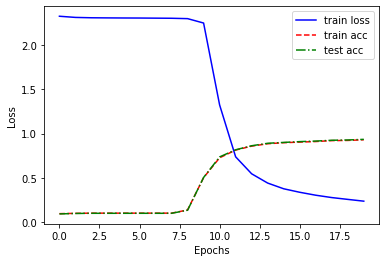

In [129]:
dropout1,dropout2 = 0.05, 0.1
LeNet_5_dropout = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Dropout(dropout1),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Dropout(dropout2),
    nn.Linear(84, 10))

training_loop(LeNet_5_dropout, train_loader, test_loader, num_epochs, lr, device)